The three-line y-average graph for the paper.

Continued from `p2021-0614a_three-line-Yavg.ipynb`,
and also borrowing just a little from:

- `p2021-0513a_three-line-Yavg.ipynb`
- `p2021-0918a_plot_chan6_results.ipynb`


## Setup

In [1]:
import os
import os.path as osp

In [2]:
import operator
import itertools

In [3]:
from datetime import datetime

In [4]:
import numpy as np

In [5]:
import pandas as pd

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline

In [8]:
import matplotlib as mpl

In [9]:
#The old way
# from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

In [10]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist

In [11]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

In [12]:
mpl.rcParams['figure.dpi']= 150

In [13]:
#Uncomment for presentation
# mpl.rcParams['xtick.labelsize']="xx-large"
# mpl.rcParams['ytick.labelsize']="xx-large"

In [14]:
from matplotlib.gridspec import GridSpec

In [15]:
from matplotlib.colors import BoundaryNorm

In [16]:
import simproc

In [17]:
import simproc.requesthandler.yaml_manager as yaml_manager
import simproc.requesthandler.pickle_manager as pickle_manager
import simproc.requesthandler.locators as locators

## Constants

In [18]:
taglist=['12A','16A','20A','27pct','50pct','na_27pct']

In [19]:
dlocal_comp_list=["xx","yy","zz","avg"]

In [20]:
dlocal_fname_tmpl="D{comp}_{tag}_nd.csv"

In [21]:
pmf_fname_tmpl="pmf_noavg_{tag}.xz"

In [22]:
wdens_fname_tmpl="density_Xplane_{mtag}.pkl"

In [23]:
bbox_fname_tmpl="bbox_{tag}.csv"

In [24]:
SELTOL=1e-6

In [25]:
#For print
# font_settings={
#   "cbar_wdens": 16,
#   "cbar_dratio": 32,
#   "cbar_pmf": 16,
#   "axlabels": 12,
#   "axtitle": 14,
# }
#Intermediate
# font_settings={
#   "cbar_wdens": 20,
#   "cbar_dratio": 40,
#   "cbar_pmf": 20,
#   "axlabels": 16,
#   "axtitle": 18,
# }
#For presentation
# font_settings={
#   "cbar_wdens": 24,
#   "cbar_dratio": 40,
#   "cbar_pmf": 24,
#   "axlabels": 24,
#   "axtitle": 24,
# }

## Data folder

In [26]:
datadir=osp.abspath("../chan6")
assert osp.isdir(datadir)

In [27]:
o=locators.SetDataFolder(datafolder=datadir)

## Locators

In [28]:
#locators.folder_structure.keys()

In [29]:
locators.folder_structure.update(Unprocessed=['inputs','unprocessed'])

In [30]:
locators.folder_structure.update(Processed=['inputs','processed'])

In [31]:
locators.folder_structure.update(Manual=['inputs','manual'])

In [32]:
Unprocessed=lambda fname: self.renderstr(locators.Unprocessed(fname))

In [33]:
Processed=lambda fname: self.renderstr(locators.Processed(fname))

In [34]:
Manual=lambda fname: self.renderstr(locators.Manual(fname))

## Dummy request for loading data

In [35]:
self=simproc.requesthandler.request.Request(name="chan6.plotting")

## Data file names and paths

Manual data

In [36]:
manualdata_fpath=Manual('other_input_values.yaml')
assert osp.isfile(manualdata_fpath)

$D_{\text{local}}$

In [37]:
dlocal_fpaths={}
for tag in taglist:
  dlocal_fpaths[tag]={comp:Processed(dlocal_fname_tmpl.format(tag=tag,comp=comp)) \
                        for comp in dlocal_comp_list}

In [38]:
dloc_existence_list=[]
for fdict in dlocal_fpaths.values():
  dloc_existence_list+=[osp.isfile(fpath) for fpath in fdict.values()]
assert all(dloc_existence_list)

PMF

In [39]:
pmf_fpaths={tag:Processed(pmf_fname_tmpl.format(tag=tag)) for tag in taglist}

In [40]:
pmf_existence_list=[osp.isfile(fpath) for fpath in pmf_fpaths.values()]
assert all(pmf_existence_list)

Water density

Paths require manual data; see below.

Bounding Box data

In [41]:
bbox_fpaths={tag:Processed(bbox_fname_tmpl.format(tag=tag)) for tag in taglist}

Plot output folder

In [42]:
postproc_top=osp.join(datadir,"postproc","notebooks")

In [43]:
assert osp.isdir(postproc_top)

## Read the input data

Manual

In [44]:
other_input_values=yaml_manager.readfile(manualdata_fpath)

In [45]:
meshes_by_tag=other_input_values["meshes_by_tag"]

$D_\text{local}$

In [46]:
dlocal_dict={}
for tag,pathdict in dlocal_fpaths.items():
  dlocal_dict[tag]= {comp:pd.read_csv(pathdict[comp]) for comp in dlocal_comp_list}

PMF

In [47]:
pmf_dict={tag:pd.read_csv(fpath) for tag,fpath in pmf_fpaths.items()}

Water density

In [48]:
wdens_fpaths={tag:Unprocessed(wdens_fname_tmpl.format(mtag=meshes_by_tag[tag])) for tag in taglist}

In [49]:
wdens_existence_list=[osp.isfile(fpath) for fpath in wdens_fpaths.values()]
assert all(wdens_existence_list)

In [50]:
wdens_dict={tag:pickle_manager.readfile(fpath) for tag,fpath in wdens_fpaths.items()}

Bounding box data

In [51]:
bbox_dict={tag:pd.read_csv(fpath,index_col=0) for tag,fpath in bbox_fpaths.items()}

## Output plot paths

In [52]:
datestr=datetime.now().strftime("%Y_%m%d")
datestr

'2021_0918'

In [53]:
outdir=osp.join(postproc_top,datestr)

In [54]:
if not osp.isdir(outdir):
  os.makedirs(outdir)
assert osp.isdir(outdir)

## Constants and Functions for plotting

In [55]:
def select_by_coord(inframe,col,val,tol=SELTOL):
  cond=(inframe[col]<(val+tol)) & (inframe[col]>(val-tol))
  sel=inframe[cond]
  return sel

In [56]:
def average_across(inframe,selcol,avgcol,tol=SELTOL):
  vlist=list(inframe[selcol].unique())
  vlist.sort()
  rows=[]
  for vv in vlist:
    subset=select_by_coord(inframe,selcol,vv,tol)
    avg_val=subset[avgcol].mean()
    rows.append((vv,avg_val))
  outframe=pd.DataFrame(rows,columns=[selcol,avgcol])
  return outframe

In [57]:
def function_across(inframe,selcol,argcol,funcname,tol=SELTOL):
  vlist=list(inframe[selcol].unique())
  vlist.sort()
  rows=[]
  for vv in vlist:
    subset=select_by_coord(inframe,selcol,vv,tol)
    res_val=getattr(subset[argcol],funcname)()
    rows.append((vv,res_val))
  outframe=pd.DataFrame(rows,columns=[selcol,argcol])
  return outframe

In [58]:
def make_stairsteps(edgearr,valarr):
  xvals=[edgearr[0]]
  yvals=[valarr[0]]
  for idx in range(len(valarr)-1):
    xvals+=[edgearr[idx+1],edgearr[idx+1]]
    yvals+=[valarr[idx],valarr[idx+1]]
  xvals.append(edgearr[-1])
  yvals.append(valarr[-1])
  return np.array(xvals),np.array(yvals)

In [59]:
def unpack_wdens(wdens_dict):
  return wdens_dict["grid"], wdens_dict["edges"]

## Plots

We're going to use the 16A channel for this.

In [60]:
tag="16A"

In [61]:
bboxes=bbox_dict[tag]

In [62]:
pmf=pmf_dict[tag]

In [63]:
dloc=dlocal_dict[tag]["avg"]

In [64]:
wdens_grid,wdens_edges=unpack_wdens(wdens_dict[tag])

Let's do the averages of all these across the channel.

In [65]:
pmf_avg=average_across(pmf,'z','PMF')

In [66]:
pmf_min=function_across(pmf,'z','PMF','min')

In [67]:
pmf_max=function_across(pmf,'z','PMF','max')

In [68]:
dloc_avg=average_across(dloc,'z',"Davg")

In [69]:
dloc_min=function_across(dloc,'z','Davg','min')

In [70]:
dloc_max=function_across(dloc,'z','Davg','max')

Errors for the PMF and D local (variation, really, not errors)

In [71]:
pmf_errors=np.vstack([(pmf_avg['PMF']-pmf_min['PMF']).values,
                      (pmf_max['PMF']-pmf_avg['PMF']).values])
pmf_errors.shape

(2, 36)

In [72]:
dloc_errors=np.vstack([(dloc_avg['Davg']-dloc_min['Davg']).values,
                       (dloc_max['Davg']-dloc_avg['Davg']).values])
dloc_errors.shape

(2, 34)

Vertices for min/max bands

In [73]:
pmf_vertices=np.vstack([pmf_max.values,pmf_min.values[::-1]])
pmf_vertices.shape

(72, 2)

In [74]:
pmf_codes=Path.LINETO * np.ones(pmf_vertices.shape[0],dtype=Path.code_type)
pmf_codes[0] = Path.MOVETO
pmf_codes.shape

(72,)

In [75]:
pmf_path = Path(pmf_vertices, pmf_codes)

In [76]:
dloc_vertices=np.vstack([dloc_max.values,dloc_min.values[::-1]])
dloc_vertices.shape

(68, 2)

In [77]:
dloc_codes=Path.LINETO * np.ones(dloc_vertices.shape[0],dtype=Path.code_type)
dloc_codes[0] = Path.MOVETO
dloc_codes.shape

(68,)

In [78]:
dloc_path = Path(dloc_vertices, dloc_codes)

Water density

In [79]:
bboxes.loc['limits',:]

Xmin     5.75
Xmax     5.75
Xspan    0.00
Ymin     4.90
Ymax     5.50
Yspan    0.60
Zmin     4.70
Zmax     6.40
Zspan    1.70
Name: limits, dtype: float64

In [80]:
wdens_grid.shape

(229, 229)

In [81]:
[ed.shape for ed in wdens_edges]

[(230,), (230,)]

In [82]:
wdens_edges[0].min(),wdens_edges[0].max() #y in 3D

(-0.22499960000000002, 11.2250004)

In [83]:
wdens_edges[1].min(),wdens_edges[1].max() #z in 3D

(-0.22499960000000002, 11.2250004)

In [84]:
ymin=bboxes.loc['limits','Ymin']
ymax=bboxes.loc['limits','Ymax']
ymin,ymax

(4.9, 5.5)

In [85]:
y_idx_lwr=np.searchsorted(wdens_edges[0],ymin)
y_idx_upr=np.searchsorted(wdens_edges[0],ymax)-1
y_idx_lwr,y_idx_upr

(103, 114)

In [86]:
wdens_edges[0][y_idx_lwr:y_idx_upr+1]

array([4.9250004, 4.9750004, 5.0250004, 5.0750004, 5.1250004, 5.1750004,
       5.2250004, 5.2750004, 5.3250004, 5.3750004, 5.4250004, 5.4750004])

In [87]:
chan_y_slice=slice(y_idx_lwr,y_idx_upr+1)
chan_y_slice

slice(103, 115, None)

In [88]:
wdens_avg_vals=[np.mean(wdens_grid[chan_y_slice,idx]) for idx in range(wdens_grid.shape[0])]  

In [89]:
wdens_min_vals=[np.min(wdens_grid[chan_y_slice,idx]) for idx in range(wdens_grid.shape[0])]

In [90]:
wdens_max_vals=[np.max(wdens_grid[chan_y_slice,idx]) for idx in range(wdens_grid.shape[0])]

In [91]:
wdens_xvals,wdens_yvals=make_stairsteps(wdens_edges[1],wdens_avg_vals)

In [92]:
wdens_min_x,wdens_min_y=make_stairsteps(wdens_edges[1],wdens_min_vals)

In [93]:
wdens_max_x,wdens_max_y=make_stairsteps(wdens_edges[1],wdens_max_vals)

In [94]:
wdens_xvals.shape,wdens_yvals.shape

((458,), (458,))

In [95]:
wdens_vertices=np.vstack([np.vstack([wdens_max_x,wdens_max_y]).T,np.vstack([wdens_min_x,wdens_min_y]).T[::-1,:]])
wdens_vertices.shape

(916, 2)

In [96]:
wdens_codes=Path.LINETO * np.ones(wdens_vertices.shape[0],dtype=Path.code_type)
wdens_codes[0] = Path.MOVETO
wdens_codes.shape

(916,)

In [97]:
wdens_path = Path(wdens_vertices, wdens_codes)

Plot parameters

In [98]:
xlims=(4.5,6.5)

In [99]:
pmf_lims=(-5,3)

In [100]:
dloc_lims=(0,1.1)

In [101]:
wdens_lims=(0,1.5)

In [102]:
band_alpha=0.3

Plots

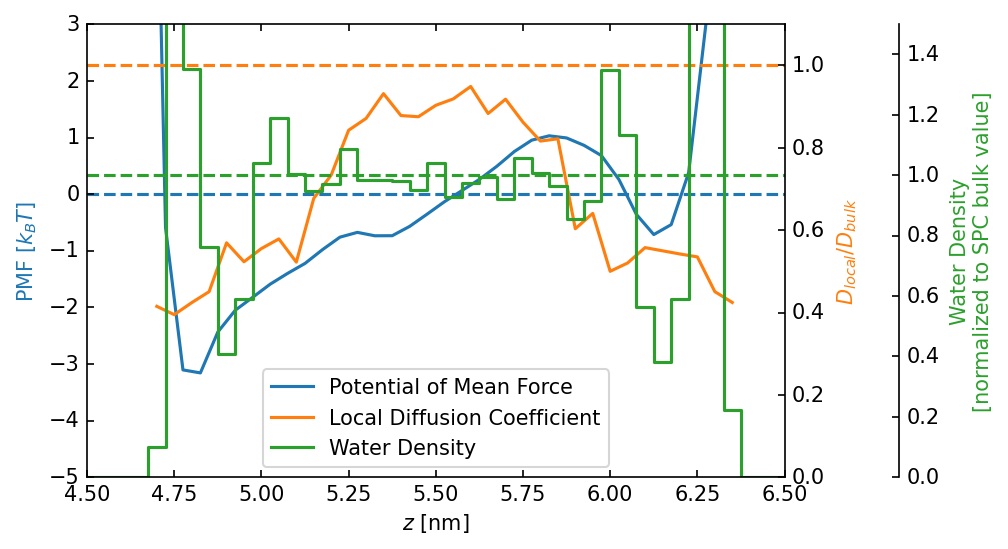

In [103]:
fig = plt.figure(figsize=(6,4))
gs=GridSpec(100,100)

#All three on the same graph, no error bars
ax_pmf = host_subplot(gs[:,:], figure=fig, axes_class=axisartist.Axes)
# fig.subplots_adjust(right=0.85)

ax_dloc = ax_pmf.twinx()
ax_wdens = ax_pmf.twinx()

ax_wdens.axis["right"] = ax_wdens.new_fixed_axis(loc="right", offset=(55, 0))

ax_dloc.axis["right"].toggle(all=True)
ax_wdens.axis["right"].toggle(all=True)

pmf_lines = ax_pmf.plot(pmf_avg['z'],pmf_avg["PMF"], label="Potential of Mean Force")
dloc_lines = ax_dloc.plot(dloc_avg['z'],dloc_avg['Davg'], label="Local Diffusion Coefficient")
wdens_lines = ax_wdens.plot(wdens_xvals, wdens_yvals, label="Water Density")

pmf_color=pmf_lines[0].get_color()
dloc_color=dloc_lines[0].get_color()
wdens_color=wdens_lines[0].get_color()

o=ax_pmf.plot(xlims,[0.0,0.0],"--",color=pmf_color)
o=ax_dloc.plot(xlims,[1.0,1.0],"--",color=dloc_color)
o=ax_wdens.plot(xlims,[1.0,1.0],"--",color=wdens_color)

ax_pmf.set_xlim(*xlims)
ax_pmf.set_ylim(*pmf_lims)
ax_dloc.set_ylim(*dloc_lims)
ax_wdens.set_ylim(*wdens_lims)

ax_pmf.set_ylabel("PMF [$k_BT$]")
ax_pmf.set_xlabel("$z$ [nm]")
ax_dloc.set_ylabel("$D_{local}/D_{bulk}$")
ax_wdens.set_ylabel("Water Density\n[normalized to SPC bulk value]")

ax_pmf.axis["left"].label.set_color(pmf_color)
ax_dloc.axis["right"].label.set_color(dloc_color)
ax_wdens.axis["right"].label.set_color(wdens_color)

ax_pmf.legend(loc="lower center")
legend_handles, legend_labels = ax_pmf.get_legend_handles_labels()

#Done
#fig.tight_layout() #Can't use this with these axes
plot_fpath=osp.join(outdir,"three_lines_Yavg.png")
fig.savefig(plot_fpath,dpi=150)

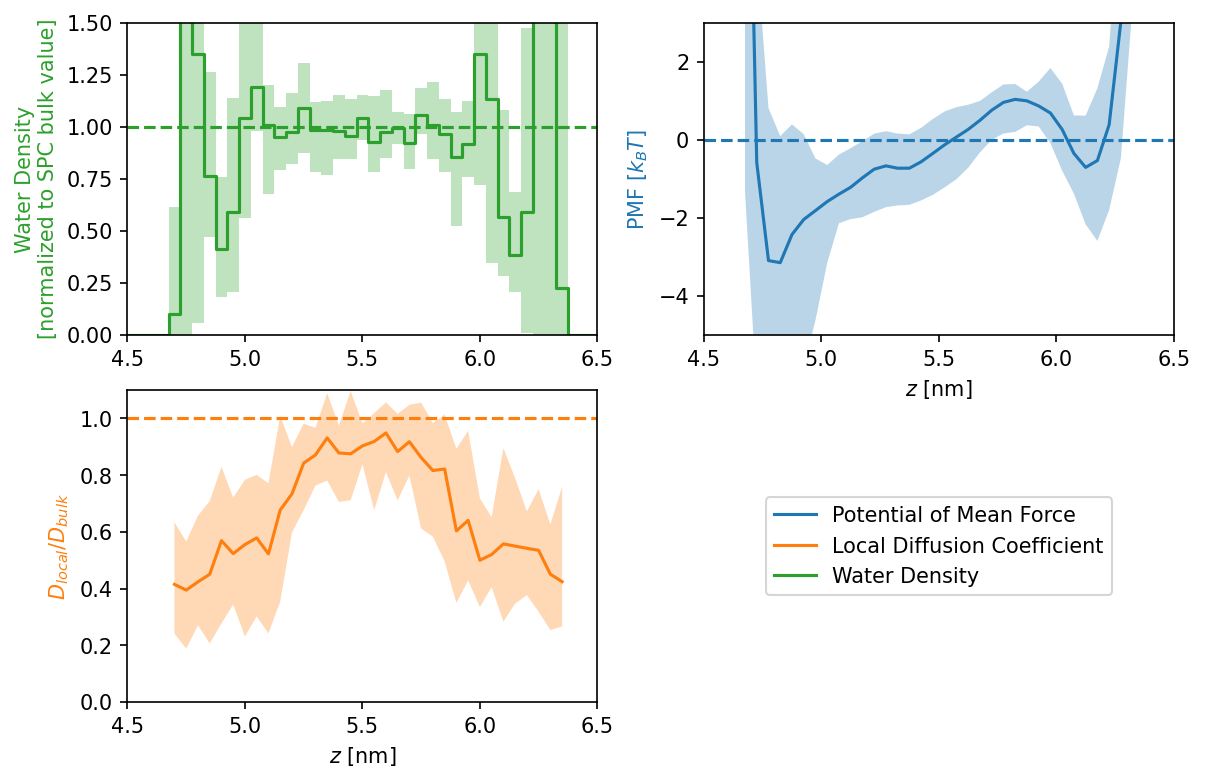

In [104]:
fig = plt.figure(figsize=(9,6))
gs=GridSpec(100,100)
y1=46
y2=54
x1=45
x2=55

#Water density only, with error bars
wdens_patch = PathPatch(wdens_path, facecolor=wdens_color, edgecolor='none', alpha=band_alpha)
ax_wdens=fig.add_subplot(gs[:y1,:x1])
o=ax_wdens.add_patch(wdens_patch)
# o=ax_wdens.plot(wdens_min_x, wdens_min_y, label="Water Density")
# o=ax_wdens.plot(wdens_max_x, wdens_max_y, label="Water Density")
o=ax_wdens.plot(wdens_xvals, wdens_yvals, color=wdens_color, label="Water Density")

o=ax_wdens.plot(xlims,[1.0,1.0],"--",color=wdens_color)

o=ax_wdens.set_xlim(*xlims)
o=ax_wdens.set_ylim(*wdens_lims)

o=ax_wdens.set_ylabel("Water Density\n[normalized to SPC bulk value]")
# o=ax_wdens.set_xlabel("$z$ [nm]")

o=ax_wdens.yaxis.label.set_color(wdens_color)


#PMF only, with variation band
pmf_patch = PathPatch(pmf_path, facecolor=pmf_color, edgecolor='none', alpha=band_alpha)
ax_pmf=fig.add_subplot(gs[:y1,x2:])
o=ax_pmf.add_patch(pmf_patch)
o=ax_pmf.plot(pmf_avg['z'],pmf_avg["PMF"], color=pmf_color, label="Potential of Mean Force")
# o = ax_pmf.errorbar(pmf_avg['z'],pmf_avg["PMF"], yerr=pmf_errors, 
#                      color=pmf_color, label="Potential of Mean Force")

o=ax_pmf.plot(xlims,[0.0,0.0],"--",color=pmf_color)

o=ax_pmf.set_xlim(*xlims)
o=ax_pmf.set_ylim(*pmf_lims)

o=ax_pmf.set_ylabel("PMF [$k_BT$]")
o=ax_pmf.set_xlabel("$z$ [nm]")

o=ax_pmf.yaxis.label.set_color(pmf_color)

#D local only, with variation band
dloc_patch = PathPatch(dloc_path, facecolor=dloc_color, edgecolor='none', alpha=band_alpha)
ax_dloc=fig.add_subplot(gs[y2:,:x1])
o=ax_dloc.add_patch(dloc_patch)
o=ax_dloc.plot(dloc_avg['z'],dloc_avg['Davg'], color=dloc_color, label="Local Diffusion Coefficient")
# o = ax_dloc.errorbar(dloc_avg['z'],dloc_avg['Davg'], yerr=dloc_errors, 
#                       color=dloc_color, label="Local Diffusion Coefficient")

o=ax_dloc.plot(xlims,[1.0,1.0],"--",color=dloc_color)

o=ax_dloc.set_xlim(*xlims)
o=ax_dloc.set_ylim(*dloc_lims)

o=ax_dloc.set_xlabel("$z$ [nm]")
o=ax_dloc.set_ylabel("$D_{local}/D_{bulk}$")

o=ax_dloc.yaxis.label.set_color(dloc_color)

#Legend
ax_legend=fig.add_subplot(gs[y2:,x2:])
o=ax_legend.axis("off")
o=ax_legend.legend(legend_handles,legend_labels,loc="center")
# o=ax_l.legend(reord_handles,reord_labels,loc="center",fontsize=16)


#Done
#fig.tight_layout() #Can't use this with these axes
plot_fpath=osp.join(outdir,"three_lines_Yavg_bands.png")
fig.savefig(plot_fpath,dpi=150)